In [109]:
from joblib import dump

from dask.distributed import Client
from dea_tools.classification import predict_xr
import geopandas as gpd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict

from dep_coastlines.MosaicLoader import DeluxeMosaicLoader
from dep_tools.namers import DepItemPath
from dep_tools.azure import get_container_client

from dep_coastlines.mask_model import prep_training_data

In [187]:
(
    training_data
        .assign(
            mndwi=lambda r: (r.green - r.swir16)/(r.green + r.swir16),
            ndwi=lambda r: (r.green - r.nir08)/(r.green + r.nir08),            
        )
        .loc[:,['code', 'red', 'blue', 'green', 'nir08', 'mndwi', 'ndwi']]
        .groupby('code')
        .mean()
)

,red,blue,green,nir08,mndwi,ndwi
code,,,,,,
cloud,4325.574468,4619.622340,4284.750000,2995.441489,0.197667,0.061343
coast,953.698630,849.609589,1046.842466,1456.575342,0.158538,-0.158322
deep_ocean,142.123377,393.058442,282.116883,140.142857,0.190486,0.388051
land,659.351064,483.106383,821.574468,3861.797872,-0.394265,-0.662682
noise,4397.023810,4643.642857,4516.904762,3646.809524,0.310046,0.029579
noisy_water,13.156584,126.028470,91.985765,117.590747,-0.454773,0.075602
surf,1944.425000,2760.562500,2436.887500,1249.375000,0.706628,0.302043
water,235.650794,459.936508,454.095238,151.015873,0.396163,0.487260


In [195]:
removes = ['shift', 'deep_ocean', 'water']
training_data = pd.read_csv("../data/training_data_with_features_1Feb2024.csv").query('code not in @removes')

codes = pd.DataFrame.from_records(
   [
        ("land",        1,1,0, "#064a00"),
        ("water",       2,2,0, "#3e94ea"),
        ("deep_ocean",  3,2,0, "#0f217d"),
        ("surf",        4,4,0, "#ddfeff"),
        ("coast",       5,5,0, "#ffe48b"),
        ("cloud",       6,6,1, "#a9a9a9"),
        ("noise",       7,6,1, "#e16be1"),
        ("noisy_water", 8,7,0, "#00ffff"),
        ('clean_water', 9,2,0, "#ff0000")
    ],
    columns=["code", "intcode", "simplintcode", "cloud", "color"],
)
training_data.columns

Index(['code', 'time', 'row', 'column', 'geometry', 'band', 'x', 'y',
       'spatial_ref', 'blue', 'blue_mad', 'count', 'green', 'green_mad',
       'nir08', 'nir08_mad', 'nir08_stdev', 'red', 'red_mad', 'swir16',
       'swir16_mad', 'swir22', 'swir22_mad', 'mndwi', 'ndwi', 'blue_dev',
       'blue_mad_dev', 'count_dev', 'green_dev', 'green_mad_dev', 'nir08_dev',
       'nir08_mad_dev', 'nir08_stdev_dev', 'red_dev', 'red_mad_dev',
       'swir16_dev', 'swir16_mad_dev', 'swir22_dev', 'swir22_mad_dev',
       'mndwi_dev', 'ndwi_dev', 'blue_all', 'blue_mad_all', 'count_all',
       'green_all', 'green_mad_all', 'nir08_all', 'nir08_mad_all',
       'nir08_stdev_all', 'red_all', 'red_mad_all', 'swir16_all',
       'swir16_mad_all', 'swir22_all', 'swir22_mad_all', 'mndwi_all',
       'ndwi_all'],
      dtype='object')

In [197]:
training_data = pd.read_csv("../data/training_data_with_features_1Feb2024.csv").query('code != "shift"')



training_data = training_data.join(codes.set_index("code"), on="code")
training_columns = [
        "blue",
        "blue_mad",
       "count",
        "green",
        "green_mad",
        "nir08",
       "nir08_mad",
      "nir08_stdev",
        "red",
        "red_mad",
        "swir16",
        "swir16_mad",
        "swir22",
        "swir22_mad",
        "blue_dev",
     #   "count_dev",
        "green_dev",
        "red_dev",
        "nir08_dev",
        "swir16_dev",
        "swir22_dev",
       "blue_all",
    #   "count_all",
       "green_all",
        "nir08_all",
        "red_all",
       "swir16_all",
     "swir22_all",
     "mndwi",
     "ndwi",
     "mndwi_all",
     "ndwi_all"
]
training_data = training_data.dropna(subset=training_columns)
from sklearn import preprocessing
X = training_data.loc[:, training_columns].to_numpy()
#scaler = preprocessing.StandardScaler().fit(X)
#X = scaler.transform(X)
y = training_data.simplintcode.to_numpy()
#m = LogisticRegression(max_iter=1000)
m = RandomForestClassifier()
cv = cross_val_score(m, X, y, cv=10)
cxp = cross_val_predict(m, X, y, cv=10)
pd.crosstab(y, cxp)


col_0,1,2,4,5,6,7
row_0,,,,,,
1,89,0,0,4,0,1
2,0,200,1,0,7,9
4,0,0,75,5,0,0
5,6,0,2,137,1,0
6,5,14,0,4,207,0
7,2,0,0,1,0,278


In [198]:
cv.mean()

0.9388736263736265

In [199]:
full_model = m.fit(X, y)

from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(m, prefit=True)
from itertools import compress
shrunk_columns = list(compress(training_columns,model.get_support()))
X_new = model.transform(X)
cv_shrunk = cross_val_score(m, X_new, y, cv=10)
cv_shrunk.mean()


0.9148992673992673

In [194]:
X_new.shape

(1048, 11)

In [167]:
shrunk_full_model = m.fit(X_new, y)
#full_model = m.fit(X, y)

#dump(shrunk_full_model, '../data/all_classes_shrunk_31Jan.joblib')
shrunk_columns


['green',
 'nir08',
 'red',
 'swir16',
 'green_dev',
 'nir08_dev',
 'swir16_dev',
 'swir22_dev',
 'blue_all',
 'green_all',
 'nir08_all',
 'red_all',
 'swir16_all']

In [15]:
anitempath = DepItemPath(
        sensor="ls",
        dataset_id="coastlines/mosaics-corrected",
        version="0.6.0",
        time="1999_2023",
        zero_pad_numbers=True,
)
loader = DeluxeMosaicLoader(
    itempath=anitempath,
)

df = pd.DataFrame([(62,30)])
df.name = (62,30)
ds = loader.load(df)

/tmp/ipykernel_914903/1410763365.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.name = (62,30)
/home/jesse/Projects/D4D/dep-coastlines/dep_coastlines/MosaicLoader.py:127: UserWarning: No items in folder dep_ls_coastlines/mosaics-corrected/0-6-0/062/030/2002
  warnings.warn(f"No items in folder {self._itempath._folder(area.name)}")
/home/jesse/Projects/D4D/dep-coastlines/dep_coastlines/MosaicLoader.py:127: UserWarning: No items in folder dep_ls_coastlines/mosaics-corrected/0-6-0/062/030/2005
  warnings.warn(f"No items in folder {self._itempath._folder(area.name)}")


<xarray.Dataset>
Dimensions:      (y: 953, x: 748)
Coordinates:
    band         int64 1
  * x            (x) float64 7.221e+05 7.222e+05 ... 7.445e+05 7.445e+05
  * y            (y) float64 -9.297e+05 -9.298e+05 ... -9.583e+05 -9.583e+05
    spatial_ref  int64 0
Data variables: (12/20)
    blue         (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>
    blue_mad     (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>
    count        (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>
    green        (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>
    green_mad    (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>
    nir08        (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>
    ...           ...
    blue_all     (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>
    green_all    (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>
    nir08_all    (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>
    red_all      (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>
    swir16_all   (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>
    swir22_all   (y, x) float32 dask.array<chunksize=(953, 748), meta=np.ndarray>

In [23]:
with Client():
    output = predict_xr(full_model, ds[training_columns], clean=True).Predictions
output = output.where(~np.isnan(ds.red)).rio.write_crs(ds.red.rio.crs)
del output.attrs['grid_mapping']
output.rio.to_raster('scratch_9923_with_all.tif', overwrite=True)

predicting...


/home/jesse/Projects/D4D/dep-coastlines/venv/lib/python3.10/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


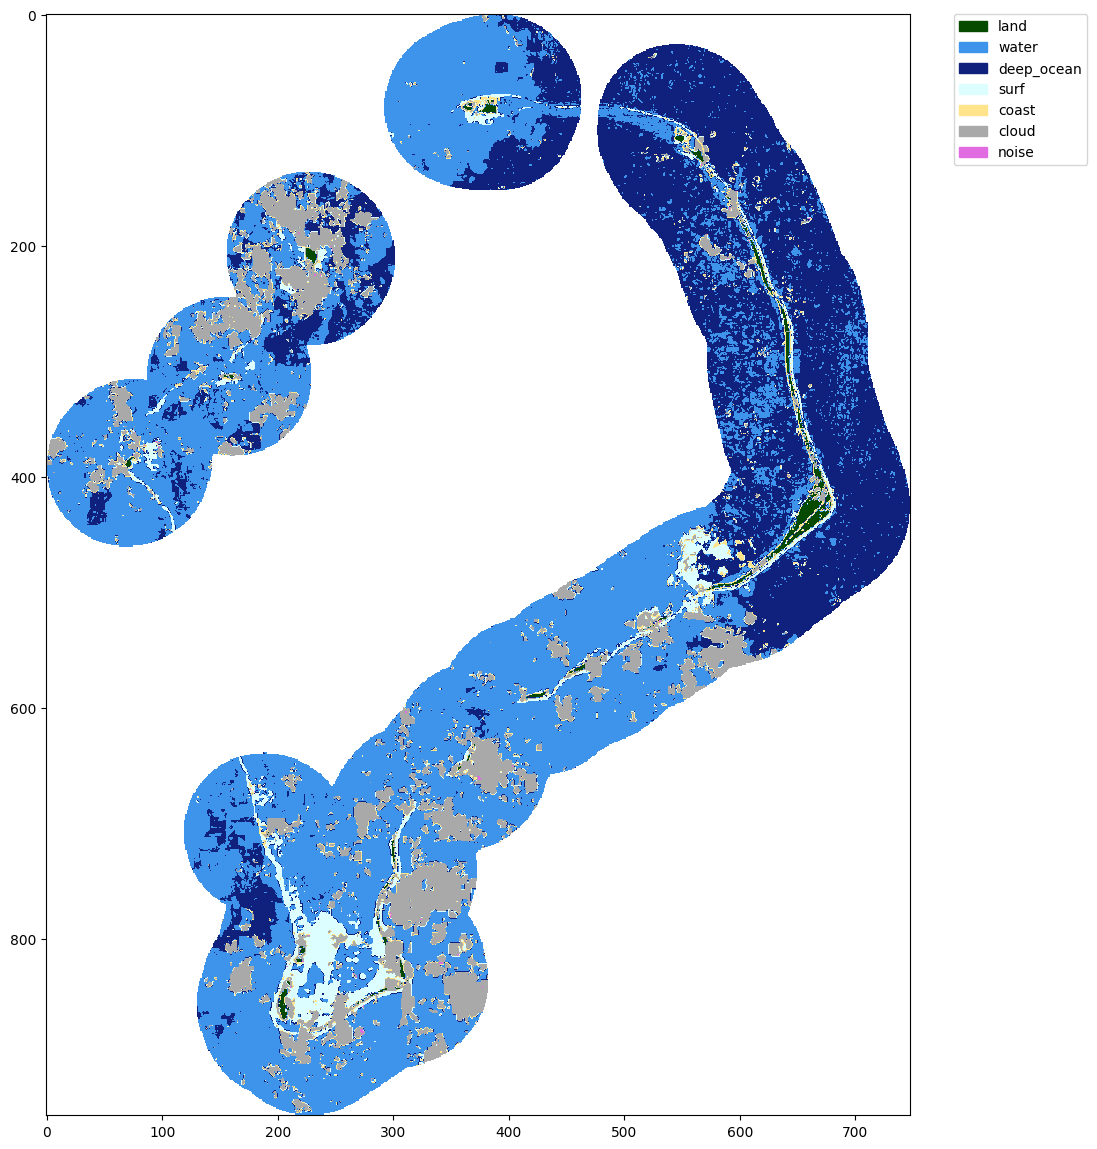

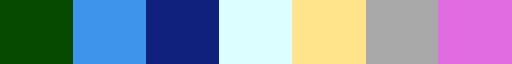

In [120]:
# Plot output as image
%matplotlib inline

#codes = codes.set_index('intcode')
colormap = ['#ffffff'] * (max(codes.index))
for i in codes.index:
  colormap[i-1] = codes.loc[i,'color']

legend_patches = [ mpatches.Patch(color=codes.loc[i].color, label=codes.loc[i].code) 
                  for i in codes.index 
                   if i in np.unique(output)
                 ]
plt.figure(figsize=(19.2, 14.3))
cmap = ListedColormap(colormap)
plot = plt.imshow(output, cmap=cmap)
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(False)
plt.show()